In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_supp_resist, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

In [2]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

## Test effectiveness of support and resistance in option trading

### Strategy 1:
* Touch support: long call
* Touch resistance: long put

#### Fail

### Strategy 2:

* Touch support
    * reflect: long call
    * break: long put
* Touch resistance:
    * reflect: long put
    * break: long call
    
#### Key question: how to confirm break / reflect?

* Assumption1.1: when going down, a short red line / long green line confirm reflect; long red line confirm break
* Assumption1.2: when going up, a short green line / long red line confirm reflect; long green line confirm break


#### Stop revenue needed; for conservative, start with 20%.

#### Precision of level should be relative to the stock price.

In [111]:
from dateutil.relativedelta import relativedelta

def test_option_trading(stock_name):
    df = yf.download(stock_name.upper(),
                     start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                     end=datetime.today().strftime('%Y-%m-%d'))
    df = df.reset_index()

    low_clusters = get_optimum_clusters(df[['Date',"Low"]].set_index('Date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df[['Date',"High"]].set_index('Date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    close = df.iloc[-1]['Close']
    support = max([e[0] for e in low_centers if e < close])
    resistance = min([e[0] for e in high_centers if e > close])
    print('previous stock price closing', round(close,1), '~ up', round(resistance,1), ', down', round(support,1))
    print(low_centers)
    print(high_centers)

    ax = plot_candlestick(df, figsize=(32,8))
    ax.set_title('qqq')
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')

    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')

    df['9_MA'] = df['Close'].rolling(window=9).mean()
    df['20_MA'] = df['Close'].rolling(window=20).mean()
    df['50_MA'] = df['Close'].rolling(window=50).mean()

    ax.plot(df['Date'], df['Close'], color='black')
    ax.plot(df['Date'], df['9_MA'], ls='--')
    ax.plot(df['Date'], df['20_MA'], ls='--')
    ax.plot(df['Date'], df['50_MA'], ls='--')
    


QQQ

9/22

* Break / reflect at support / resistance

* ITM option traded price: call (, expire 9/22), 

* Option profitability EOD: 

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 357.9 ~ up 368.6 , down 353.5
[[261.78476315]
 [270.4640729 ]
 [279.77066854]
 [290.32862065]
 [303.5216713 ]
 [316.82290256]
 [332.90222168]
 [353.54000136]
 [364.97028721]
 [375.71356964]]
[[268.11762056]
 [276.64083227]
 [285.28676471]
 [296.33793167]
 [309.89291509]
 [321.38839033]
 [336.72285679]
 [355.86845985]
 [368.57305484]
 [379.60562515]]


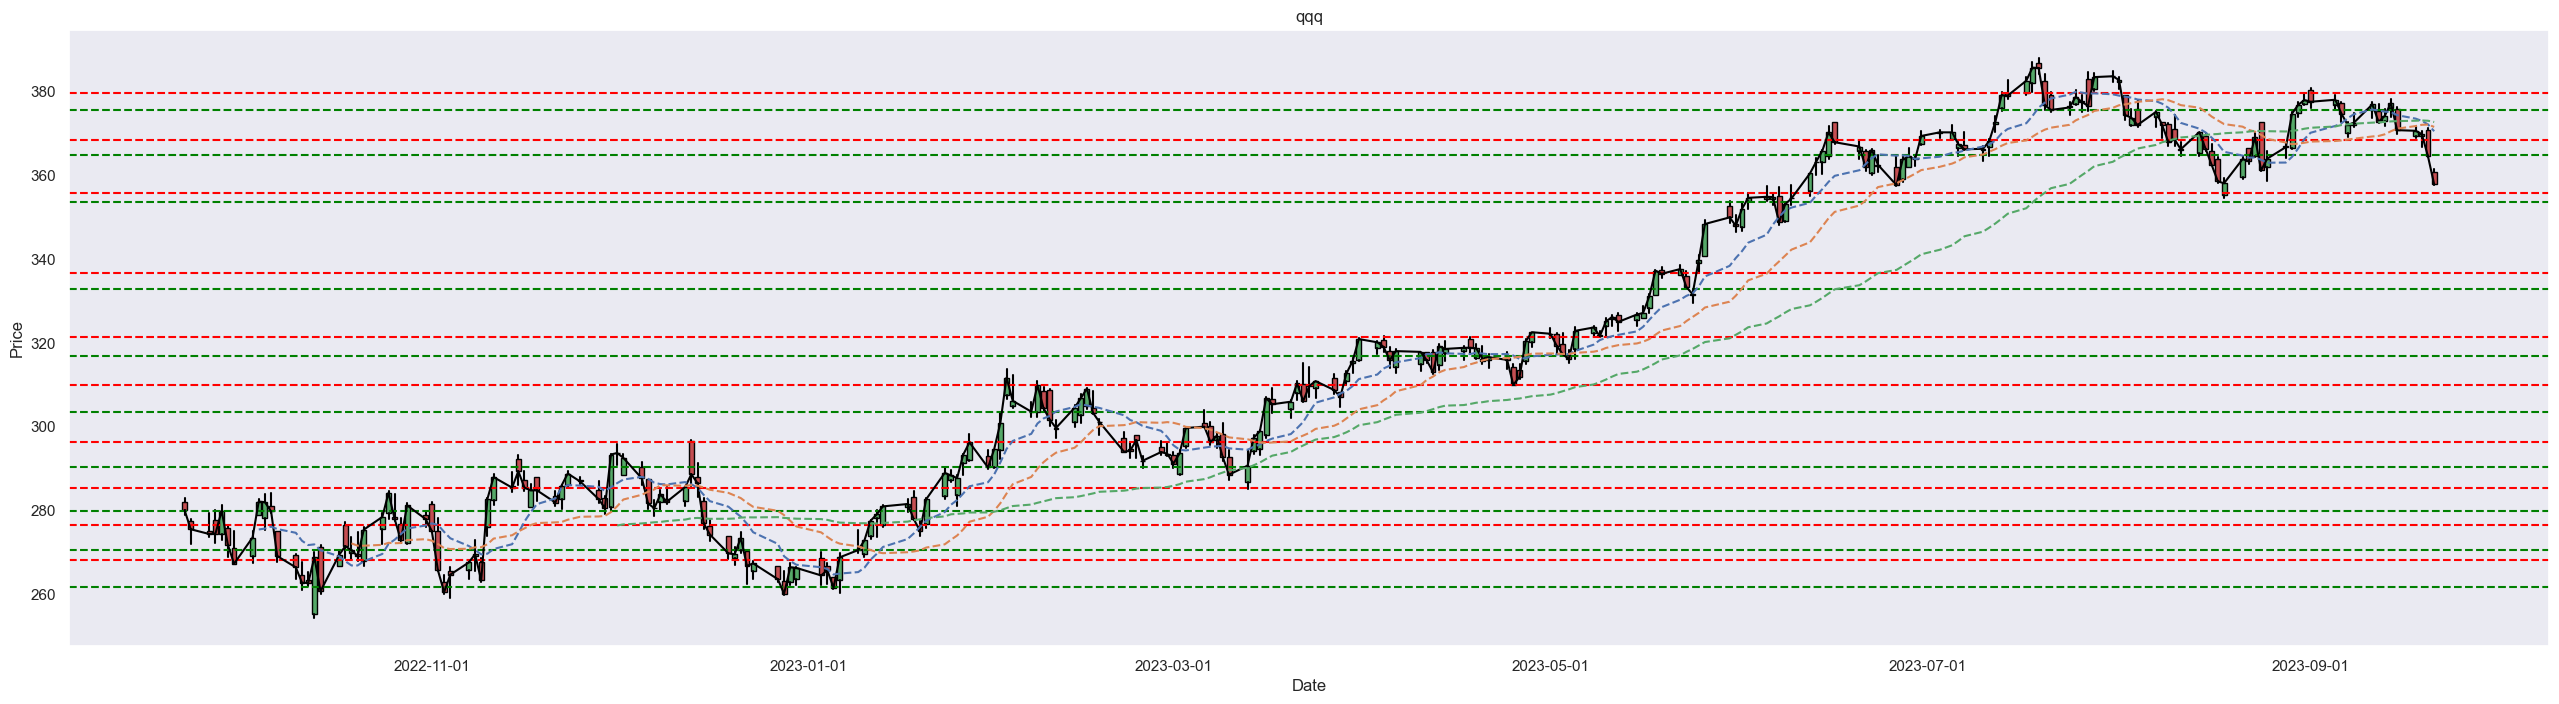

In [112]:
test_option_trading('qqq')

SPY 

9/22

* previous stock price closing 431 ~ up 444.6, down 431

* Break / reflect at support / resistance: reflect at support 431

* ITM option traded price: call (strike 432, expire 9/29), 3.92 

* Option profitability EOD: 3.21; highest after: 4.8

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 431.4 ~ up 434.5 , down 412.5
[[359.17874908]
 [370.97916412]
 [379.64000005]
 [389.41304746]
 [395.99105112]
 [406.06000126]
 [412.50310437]
 [431.76043701]
 [441.59233195]
 [450.45332972]]
[[368.48250008]
 [379.01571437]
 [387.00130297]
 [397.90386616]
 [405.46000163]
 [413.18833415]
 [419.80818315]
 [434.53368016]
 [444.55193403]
 [453.52111138]]


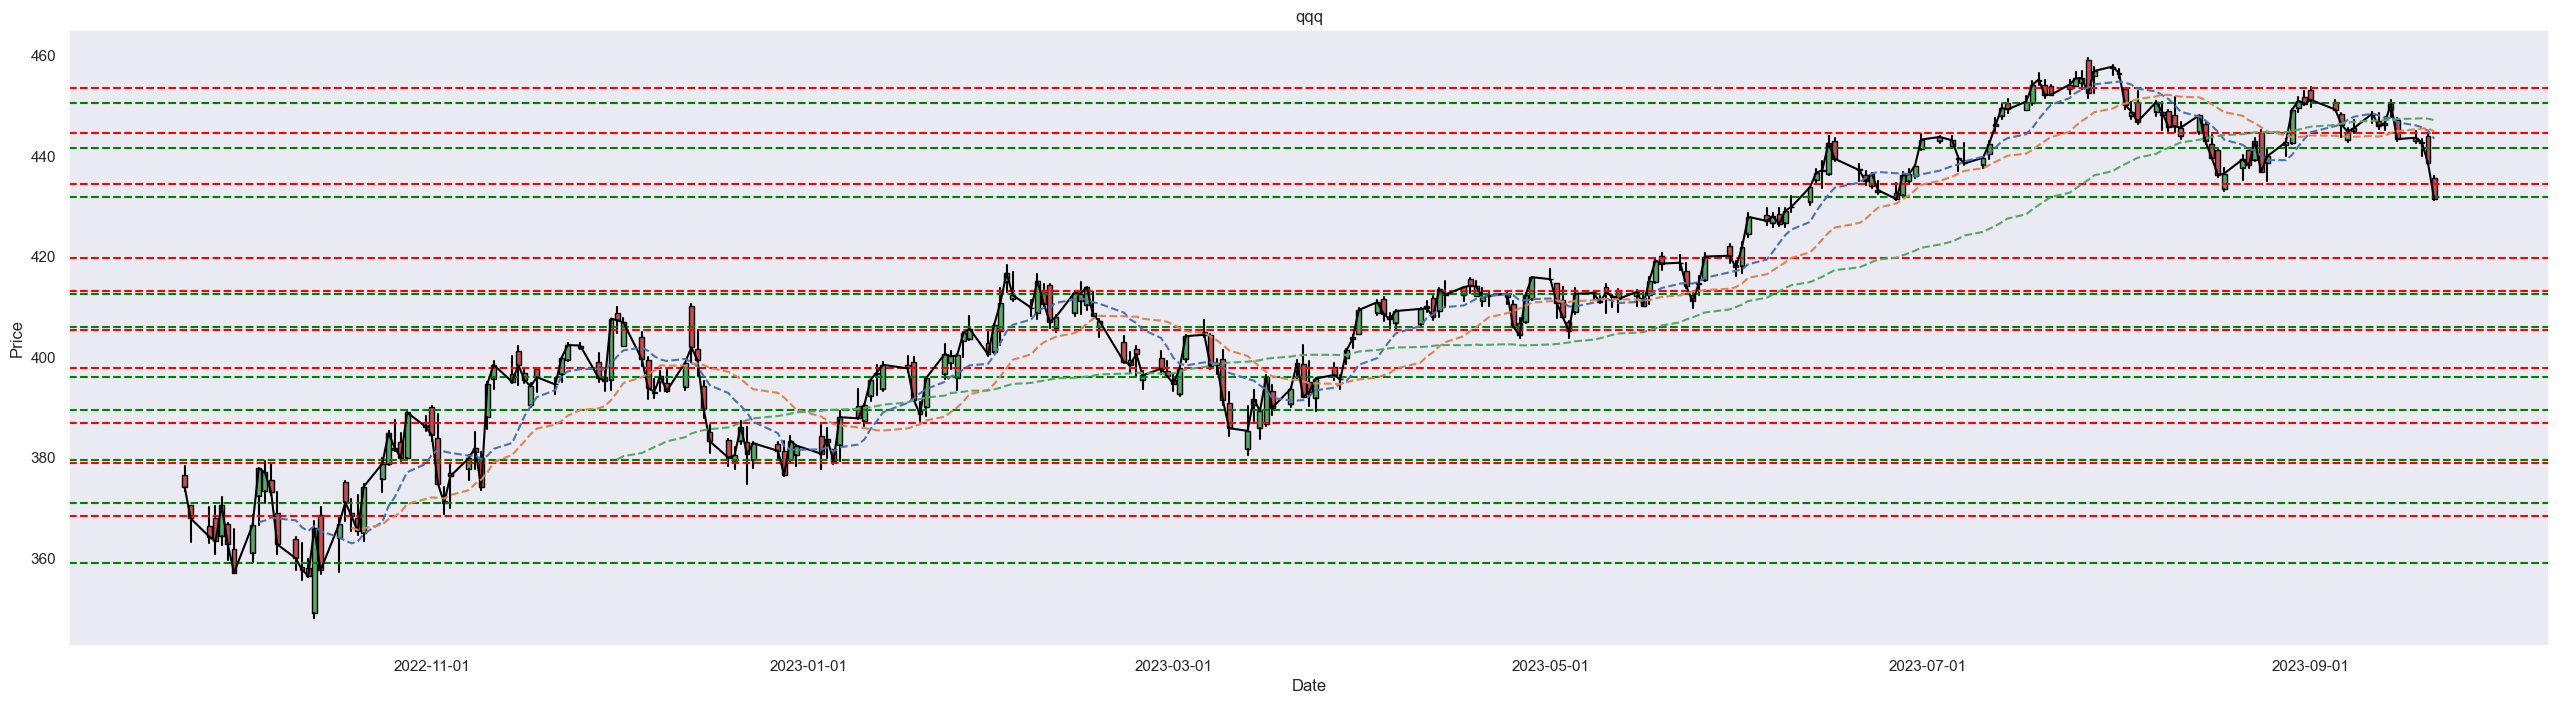

In [113]:
test_option_trading('spy')

GOOGL 

9/22

* previous stock price closing 130 ~ up 131.2, down 128.8

* Break / reflect at support / resistance: resistance 131

* ITM option traded price: 

* Option profitability EOD: 

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 130.4 ~ up 131.2 , down 128.9
[[ 86.54299965]
 [ 90.16499996]
 [ 93.78137891]
 [ 96.8019355 ]
 [100.08818193]
 [104.49909071]
 [117.73571523]
 [122.26199977]
 [128.87080017]
 [134.85624981]]
[[ 88.81421139]
 [ 92.13954613]
 [ 96.14178603]
 [ 99.44483849]
 [102.22499943]
 [107.02228546]
 [120.01388931]
 [124.68193596]
 [131.22461348]
 [137.16882414]]


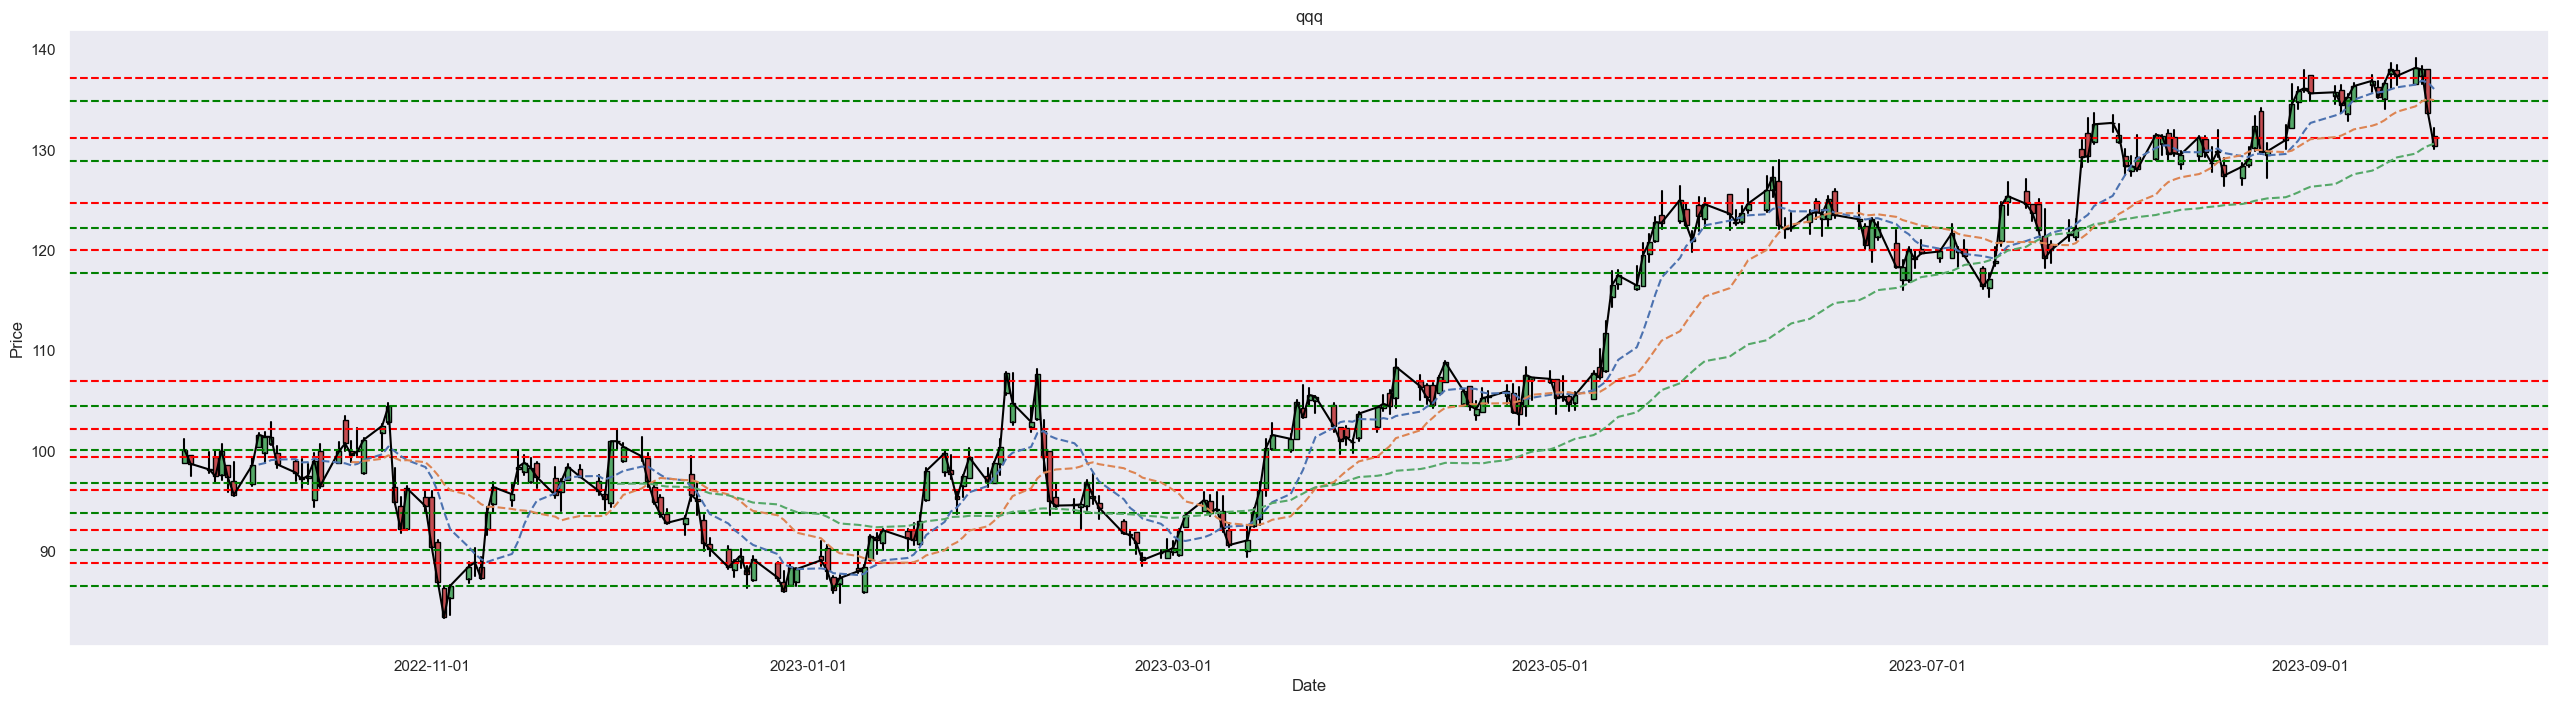

In [114]:
test_option_trading('googl')

MSFT

9/22

* previous stock price closing 319.5 ~ up 327.8, down 320.4 / 306.8

* Break / reflect at support / resistance: support 320.4

* ITM option traded price: 

* Option profitability EOD: 

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 319.5 ~ up 327.8 , down 306.8
[[223.2178947 ]
 [235.03341996]
 [243.85361099]
 [254.35363492]
 [270.41266276]
 [284.25900421]
 [306.83624649]
 [320.45310185]
 [330.22405264]
 [340.08789705]]
[[230.70600052]
 [242.14673979]
 [251.53454405]
 [262.06624985]
 [277.54333903]
 [288.85315745]
 [311.89315796]
 [327.77499866]
 [338.10439021]
 [353.60499878]]


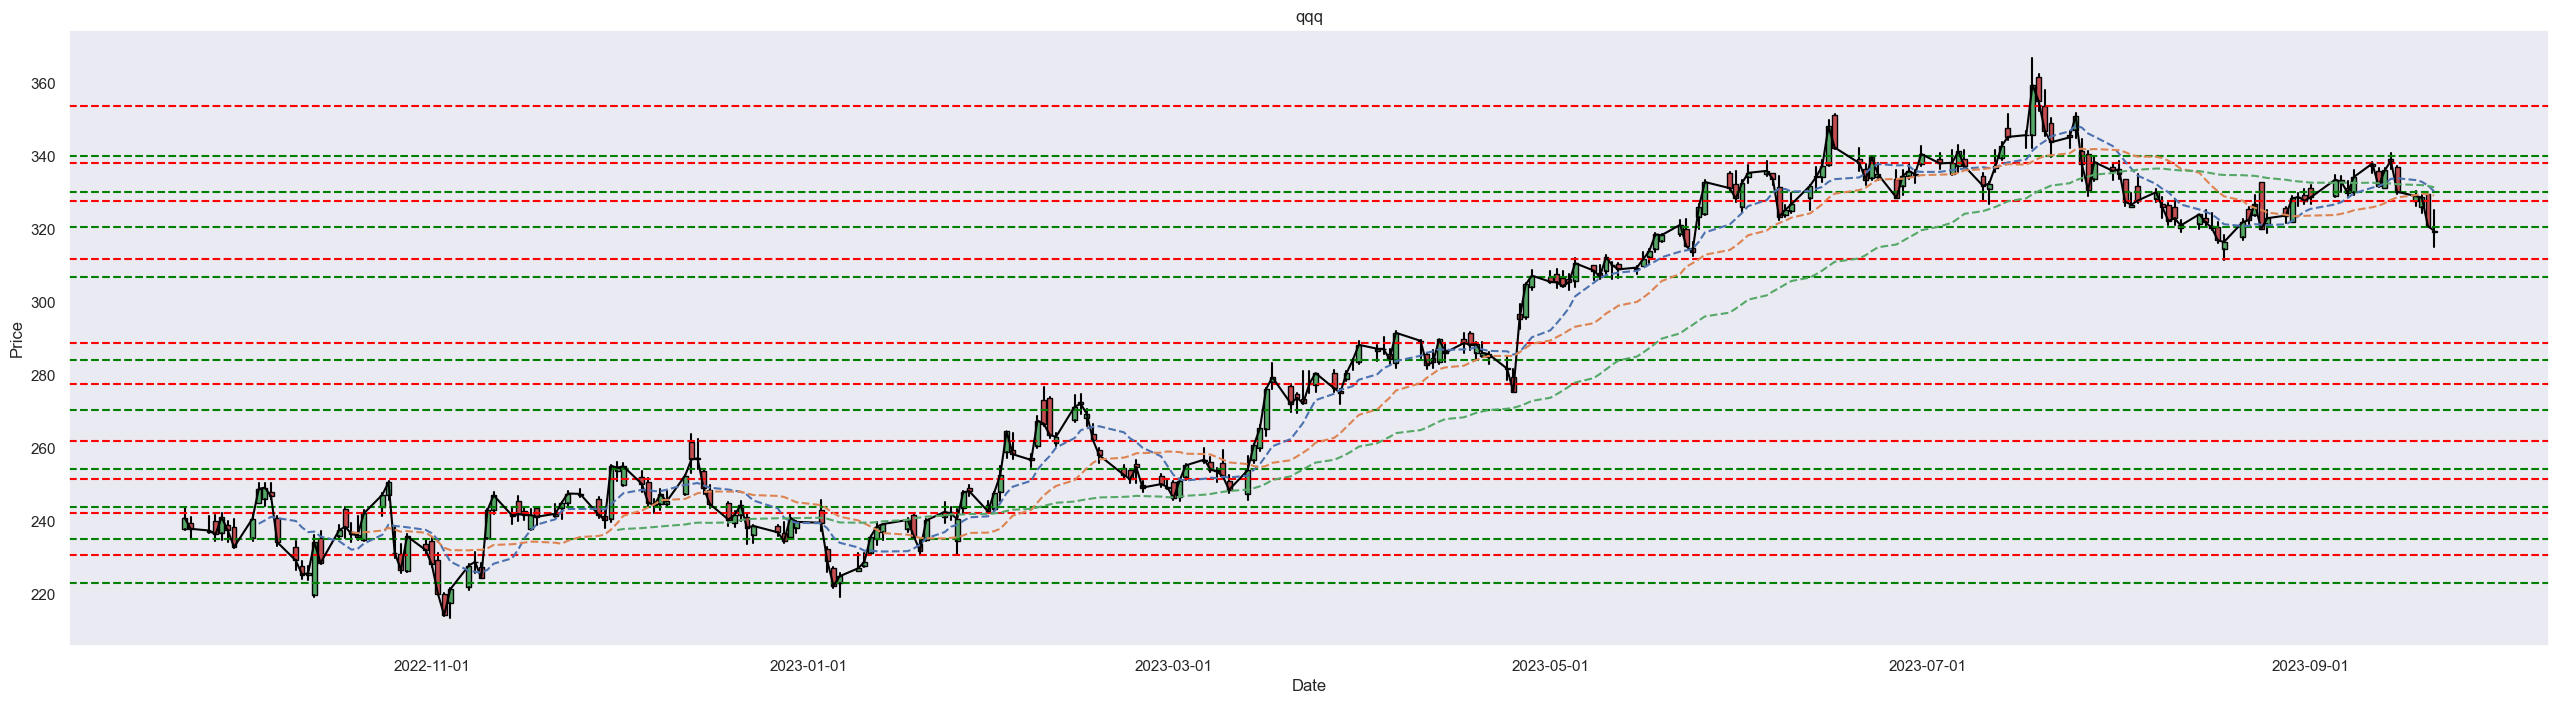

In [115]:
test_option_trading('msft')

TSLA

9/22

* previous stock price closing 255.7 ~ up 271.8, down 258.4

* Break / reflect at support / resistance: support 258.4

* ITM option traded price: 

* Option profitability EOD: 

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 255.7 ~ up 256.8 , down 241.5
[[113.58666636]
 [133.65000229]
 [161.96514195]
 [179.42023759]
 [192.18888855]
 [207.85350037]
 [222.80000051]
 [241.45079956]
 [258.4212513 ]
 [276.13222419]]
[[121.40799917]
 [140.72666592]
 [167.12714222]
 [184.01684209]
 [197.58425064]
 [215.64576956]
 [234.49240112]
 [256.81586114]
 [271.77280029]
 [287.03187752]]


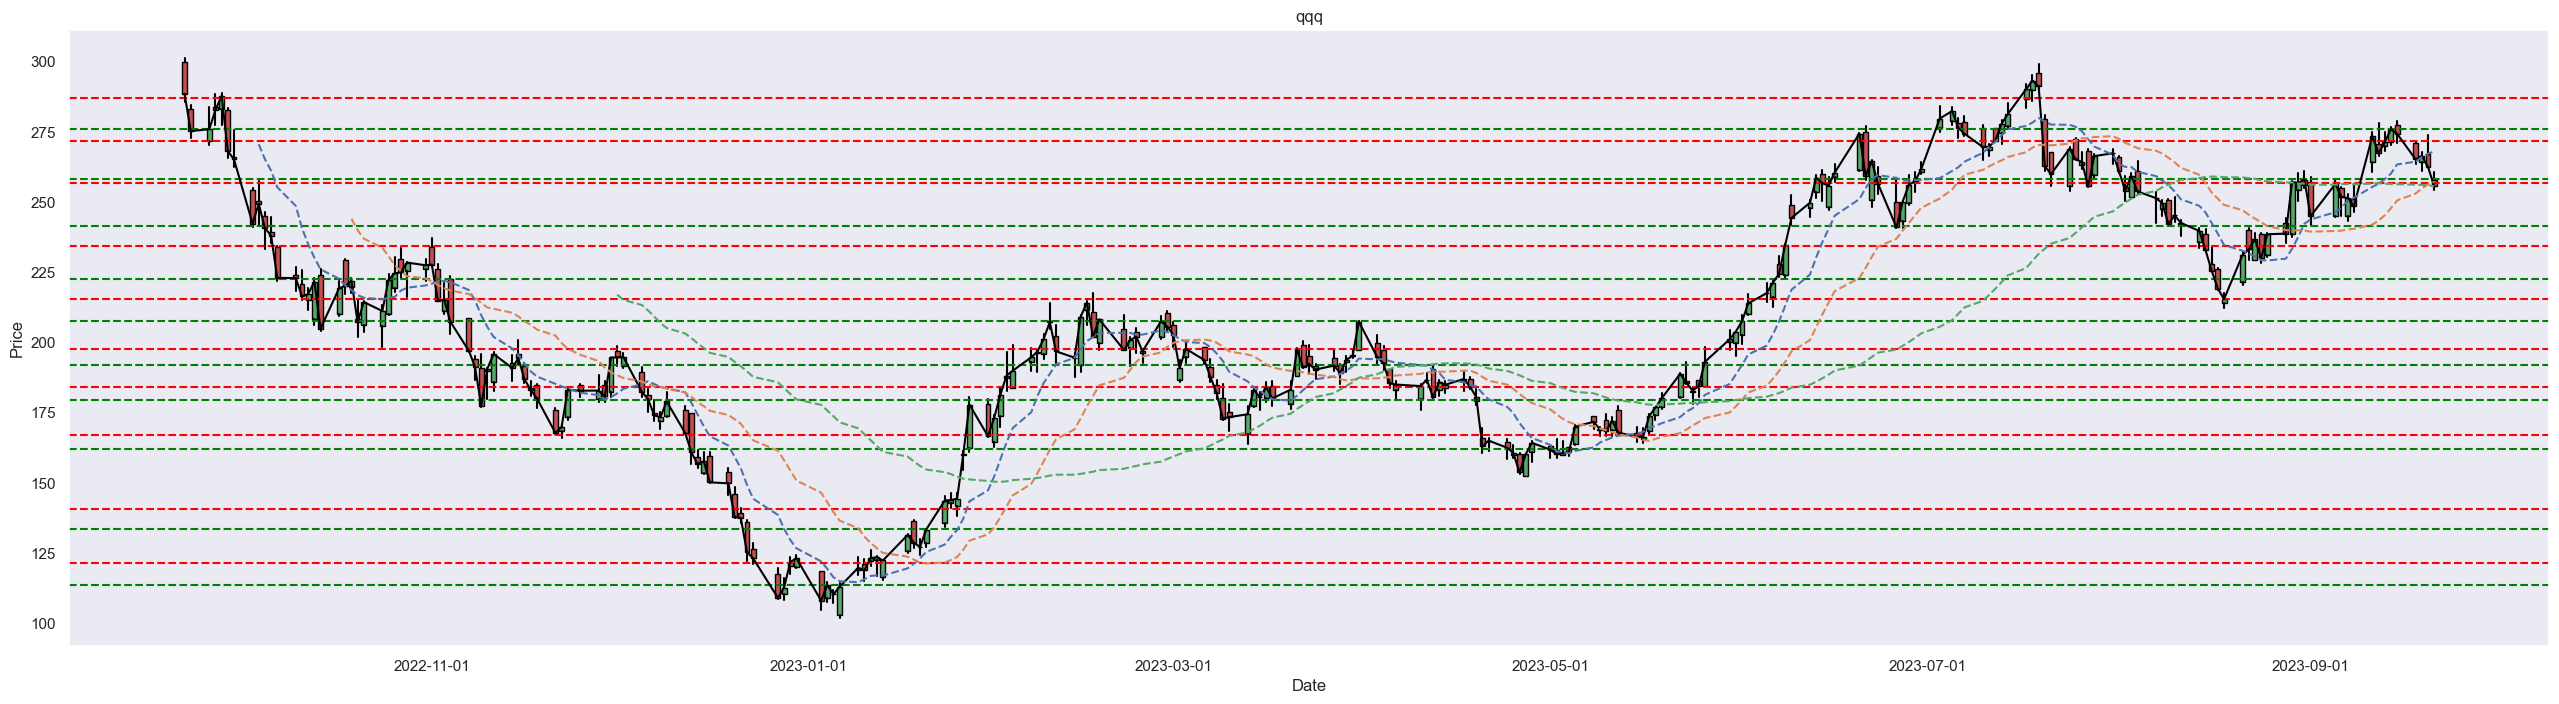

In [116]:
test_option_trading('tsla')

COF 

9/22

* previous stock price closing 98.93 ~ up 101.8, down 99.1 / 96.1

* Break / reflect at support / resistance: break support 99.1

* ITM option traded price: put (99, expire 9/29) 1.75 

* Option profitability EOD: 1.85; highest 2 

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 98.9 ~ up 101.7 , down 96.1
[[ 86.8386673 ]
 [ 90.25500003]
 [ 93.28842163]
 [ 96.14759979]
 [ 99.12757619]
 [101.86115412]
 [105.13684283]
 [108.3151847 ]
 [111.53000107]
 [115.09192335]]
[[ 89.4700002 ]
 [ 92.8061541 ]
 [ 95.52805583]
 [ 98.73628584]
 [101.72407447]
 [104.10233332]
 [107.8233341 ]
 [110.85785675]
 [115.06370403]
 [118.92210509]]


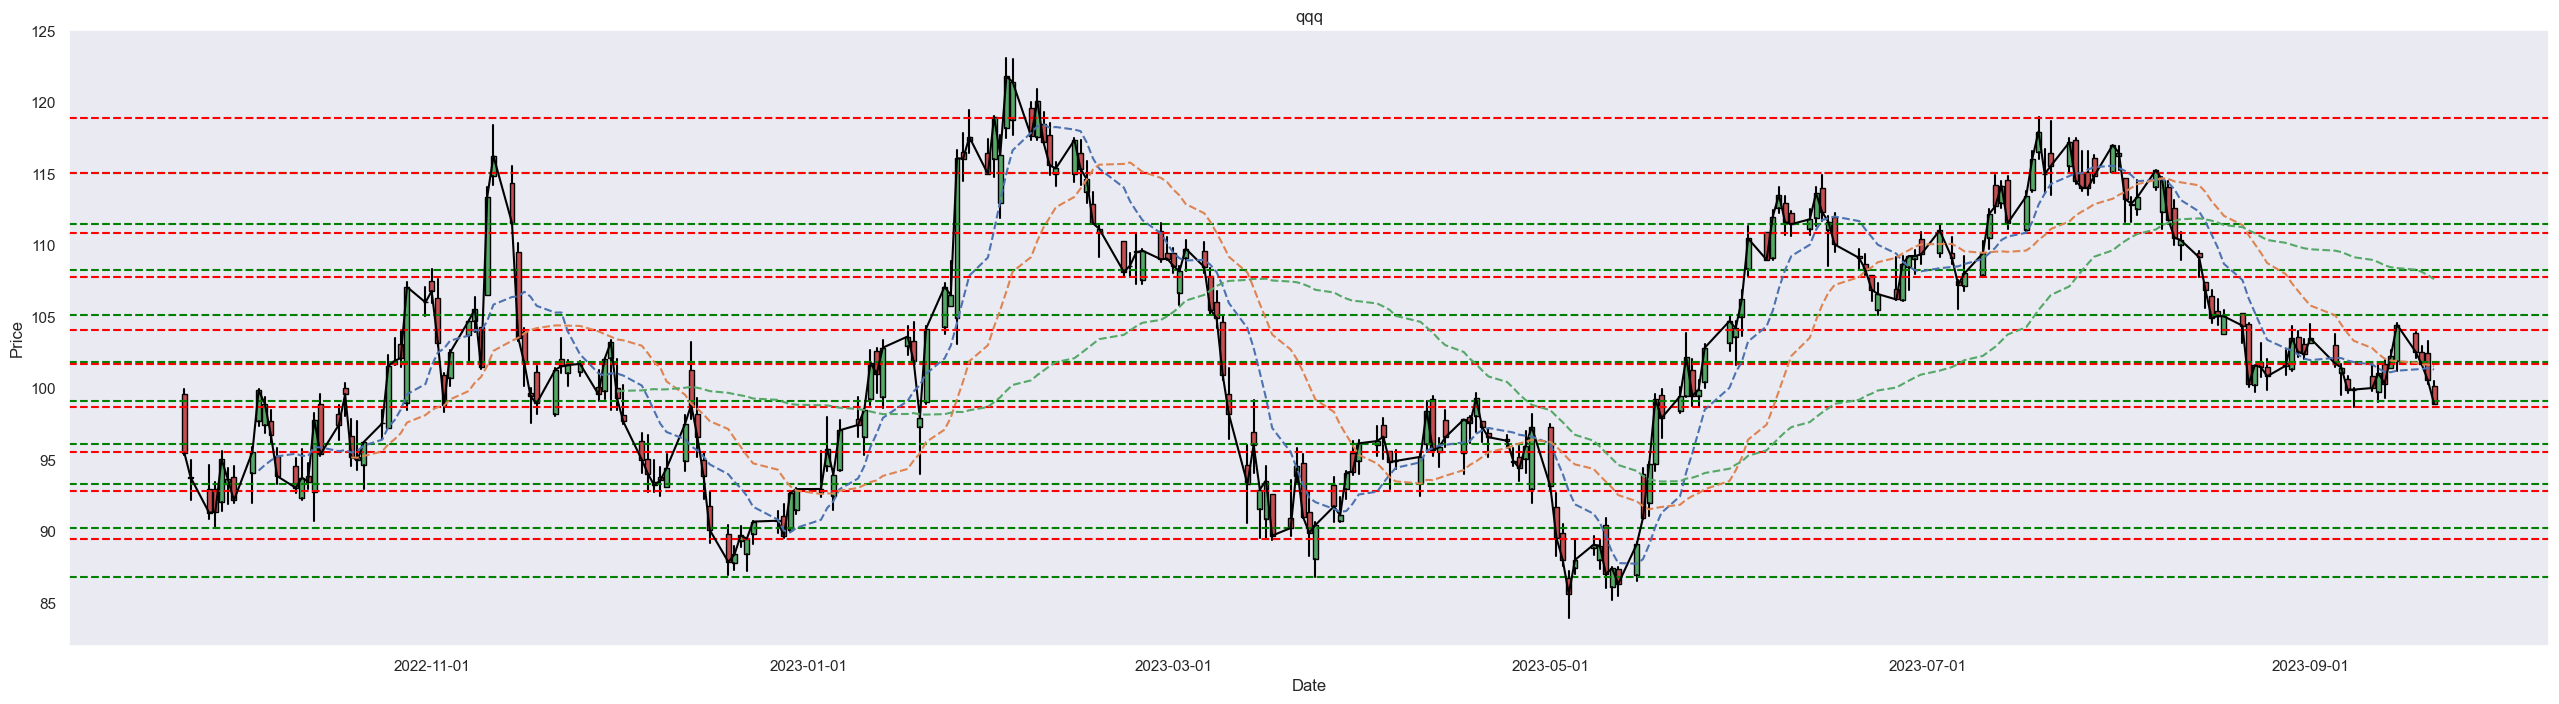

In [117]:
test_option_trading('cof')

AAPL 

9/22

* previous stock price closing 173.93 ~ up 174.5, down 172.2

* Break / reflect at support / resistance: reflect resistance 174.5

* ITM option traded price: put (strike 175, expire 9/29), 2.44

* Option profitability EOD: 2.28, highest 2.58

Back-test: no strong signal

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 173.9 ~ up 174.5 , down 172.3
[[128.31588386]
 [136.49565257]
 [142.69499969]
 [149.03933309]
 [157.0492848 ]
 [164.25333368]
 [172.29120056]
 [177.3850001 ]
 [184.64166684]
 [191.54374949]]
[[132.43894517]
 [142.0862069 ]
 [148.17057146]
 [153.47540572]
 [160.38285828]
 [166.94900055]
 [174.51347948]
 [180.2987095 ]
 [188.04521843]
 [194.78199997]]


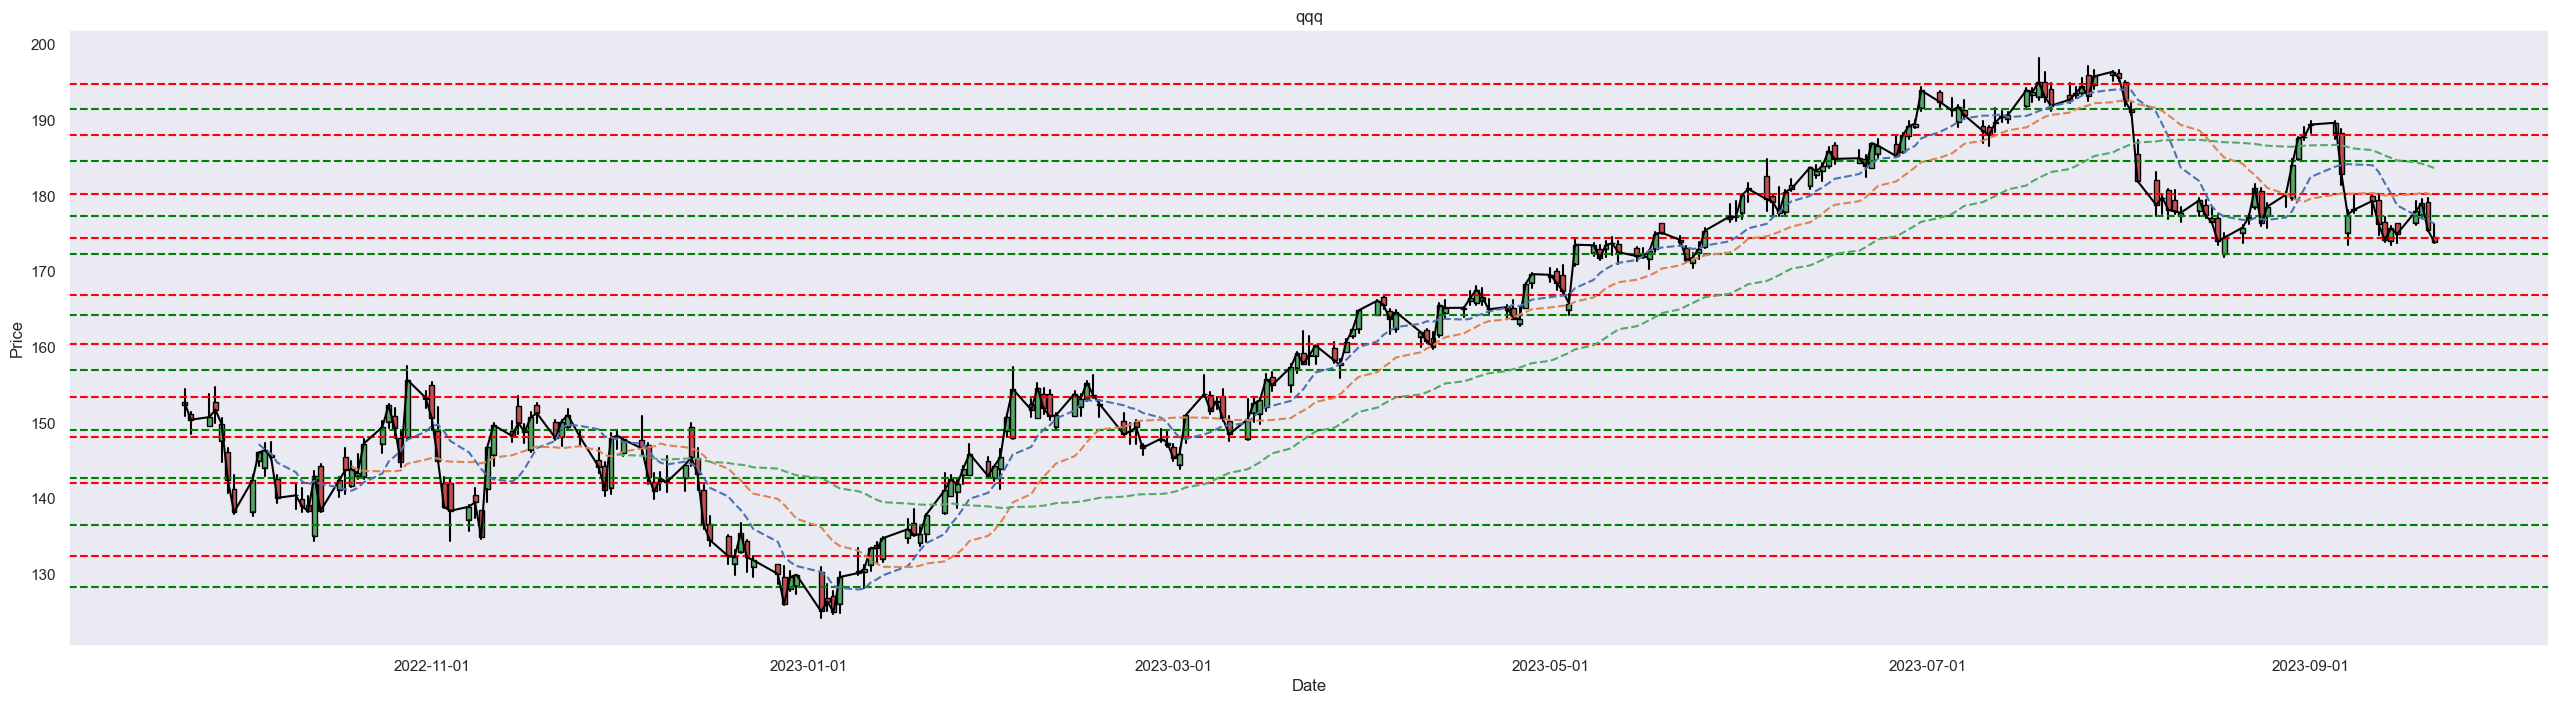

In [118]:
test_option_trading('aapl')

AMD 

9/22

* previous stock price closing 96.59 ~ up 97.7, down 94

* Break / reflect at support / resistance: break resistance 97.7

* ITM option traded price: call (97, expire 9/29) 2.83

* Option profitability EOD: 1.89, highest 2.86

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 96.1 ~ up 97.7 , down 94.1
[[ 57.90624968]
 [ 65.09361087]
 [ 71.99413799]
 [ 79.19874922]
 [ 86.02083333]
 [ 94.08846136]
 [101.43374968]
 [107.52289461]
 [114.72423143]
 [122.84625053]]
[[ 61.96258065]
 [ 68.73935478]
 [ 76.23257141]
 [ 84.71999969]
 [ 90.26714398]
 [ 97.66083399]
 [106.69629641]
 [113.06147115]
 [119.8335302 ]
 [127.43454396]]


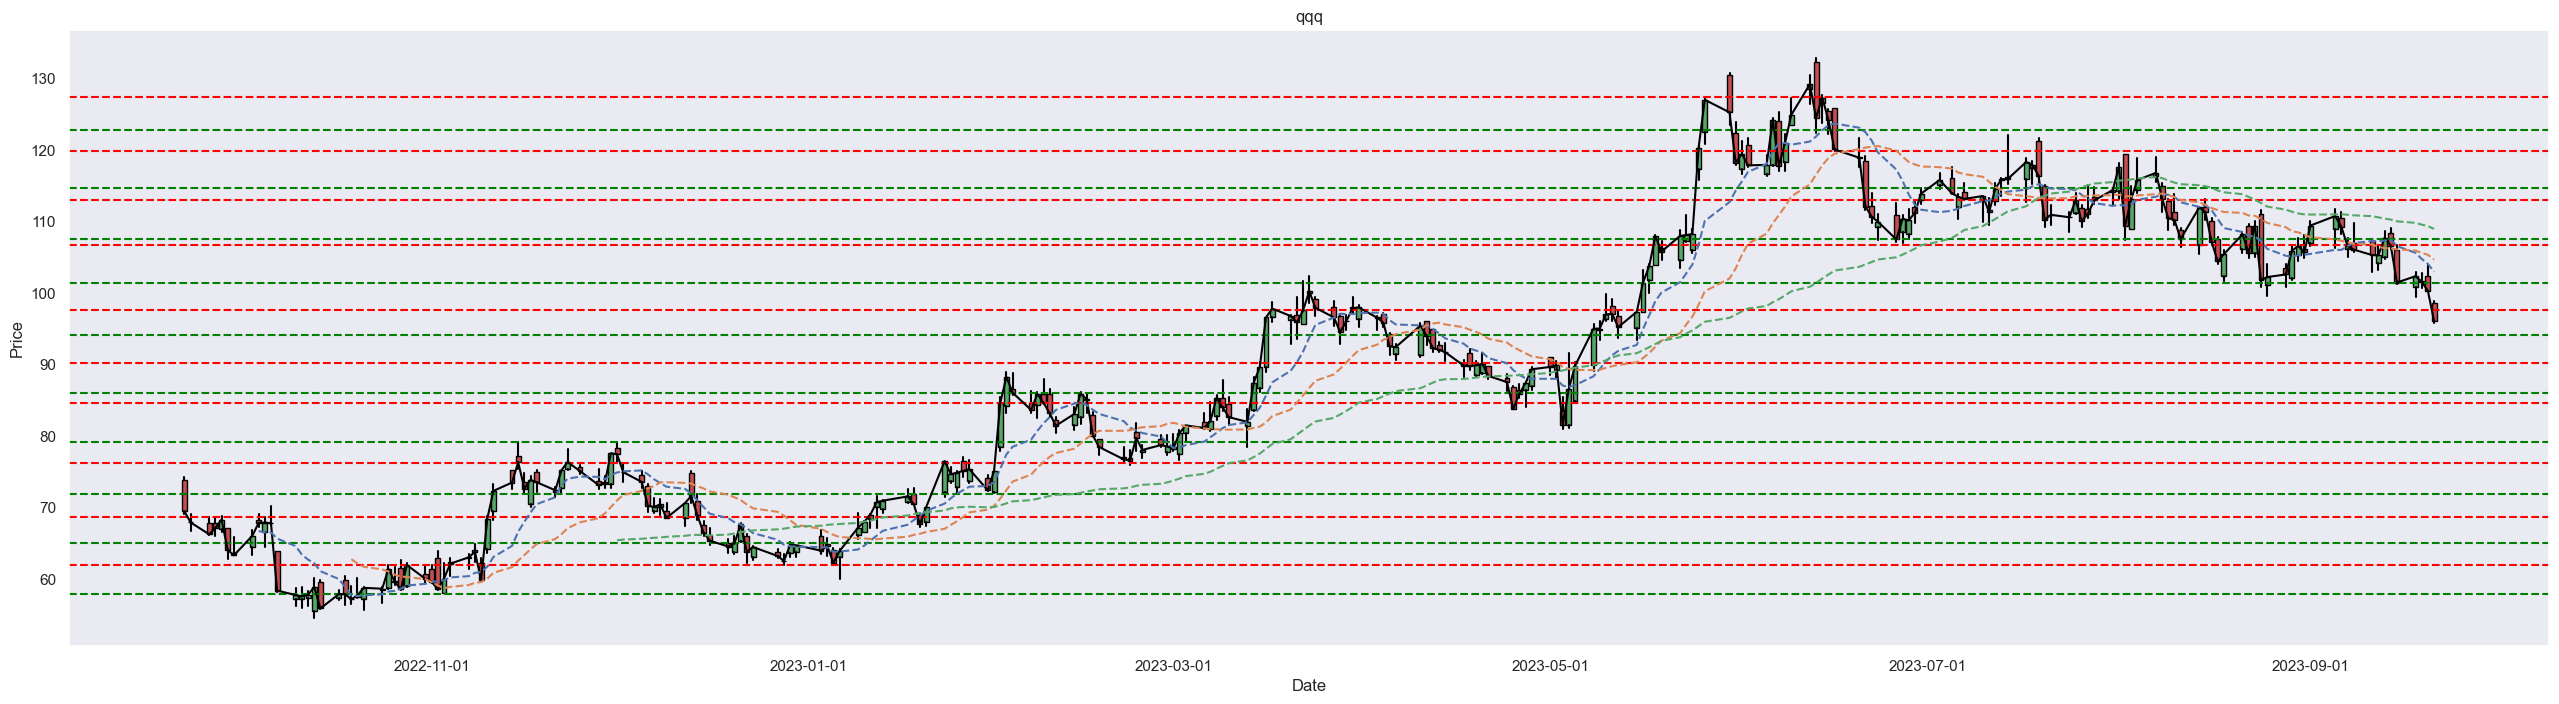

In [119]:
test_option_trading('amd')

BAC 

9/20

* Reflect at resistance 28.79

* ITM option traded price: put (29, expire 9/22), 0.24

* Option profitability EOD: 0.48
    
9/22

* previous stock price closing 28.05 ~ up 28.9, down 28.3

* Break / reflect at support / resistance: break support 28.3

* ITM option traded price: put (28, expire 9/29), 0.35

* Option profitability EOD: 0.55

backtest: break support on open without reflect

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 28.0 ~ up 28.8 , down 27.4
[[27.39518512]
 [28.27410722]
 [29.09935477]
 [30.37363633]
 [31.71884625]
 [32.70235241]
 [33.90846179]
 [35.1382352 ]
 [36.08066737]
 [37.19500024]]
[[28.01124986]
 [28.84321431]
 [29.71030299]
 [31.12842108]
 [31.97999988]
 [32.86409101]
 [34.41321441]
 [35.4844443 ]
 [36.55411731]
 [37.77999945]]


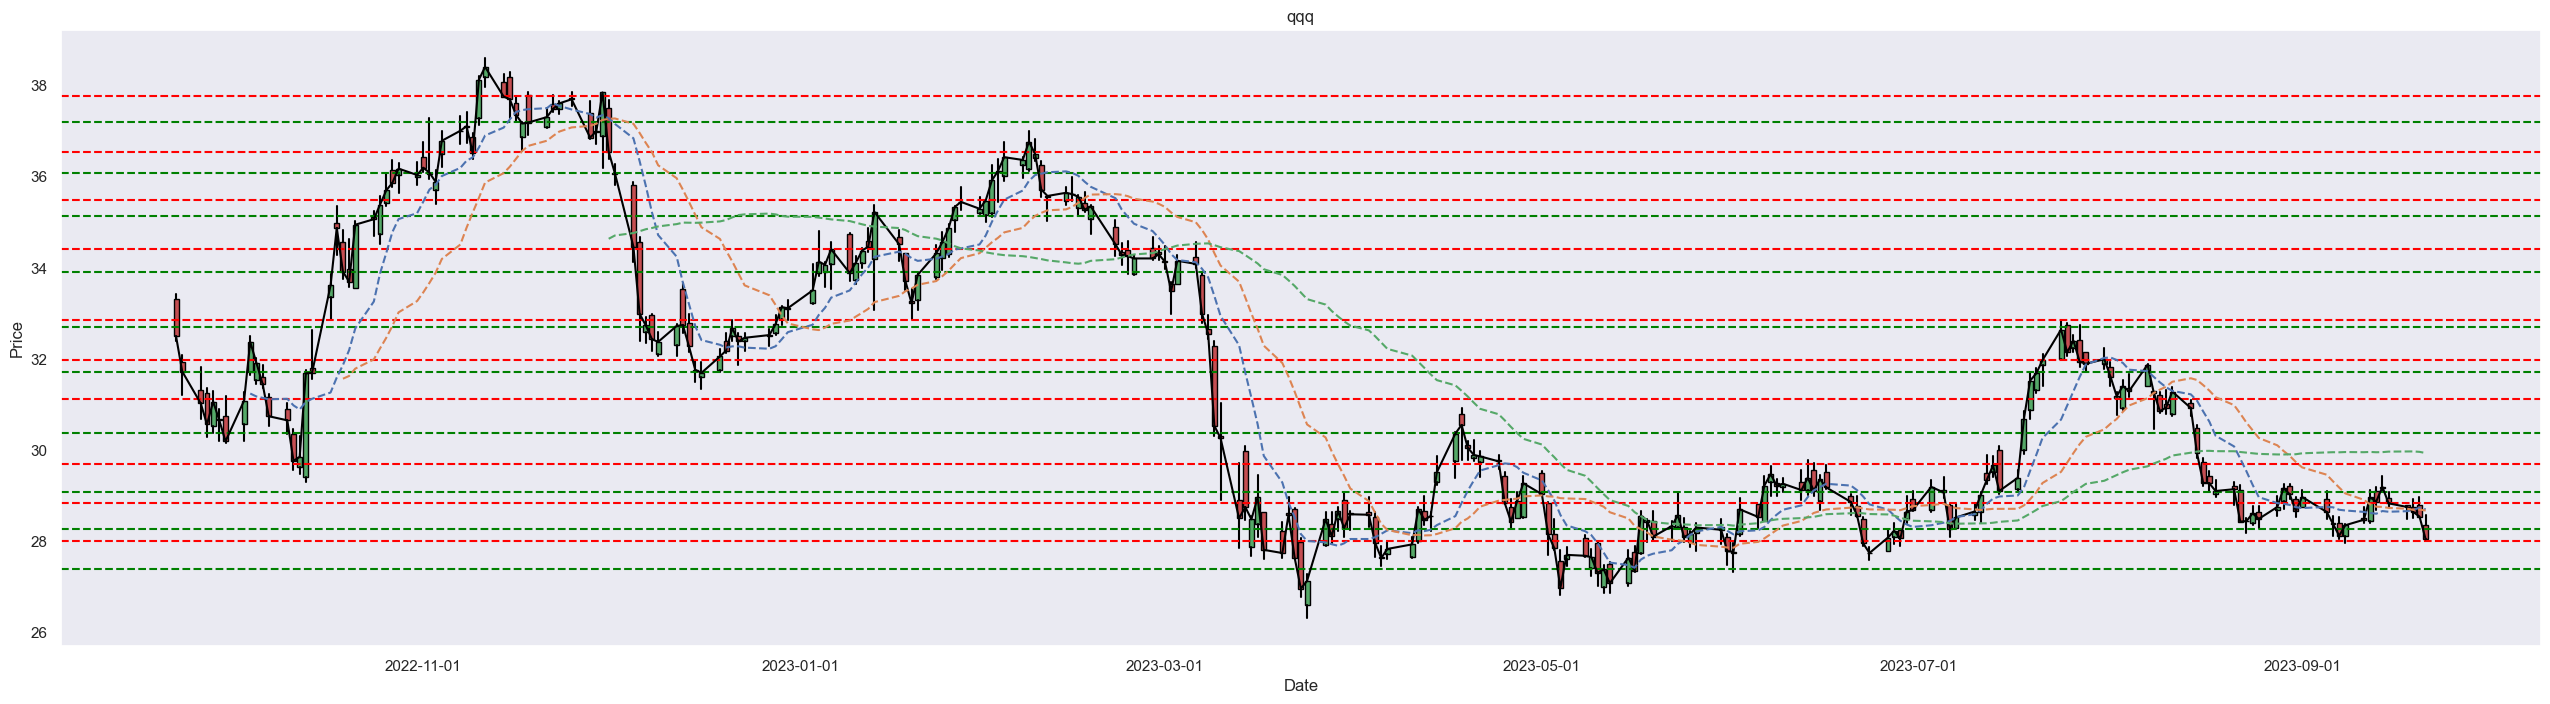

In [120]:
test_option_trading('bac')

NIO 

9/22

* previous stock price closing 8.45 ~ up 9.3, down 8.1

* Break / reflect at support / resistance: break support 8.1

* ITM option traded price: put (, expire 9/29), 

* Option profitability EOD: 

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 8.4 ~ up 9.2 , down 8.1
[[ 7.54304349]
 [ 8.14384615]
 [ 8.96425009]
 [ 9.77268298]
 [10.4644898 ]
 [11.16090905]
 [12.09119999]
 [13.32888889]
 [15.00727263]
 [17.33600006]]
[[ 8.17274997]
 [ 9.24282054]
 [10.21704552]
 [10.91133338]
 [11.63458335]
 [12.49150004]
 [13.42666668]
 [14.78499997]
 [16.35874987]
 [18.29599953]]


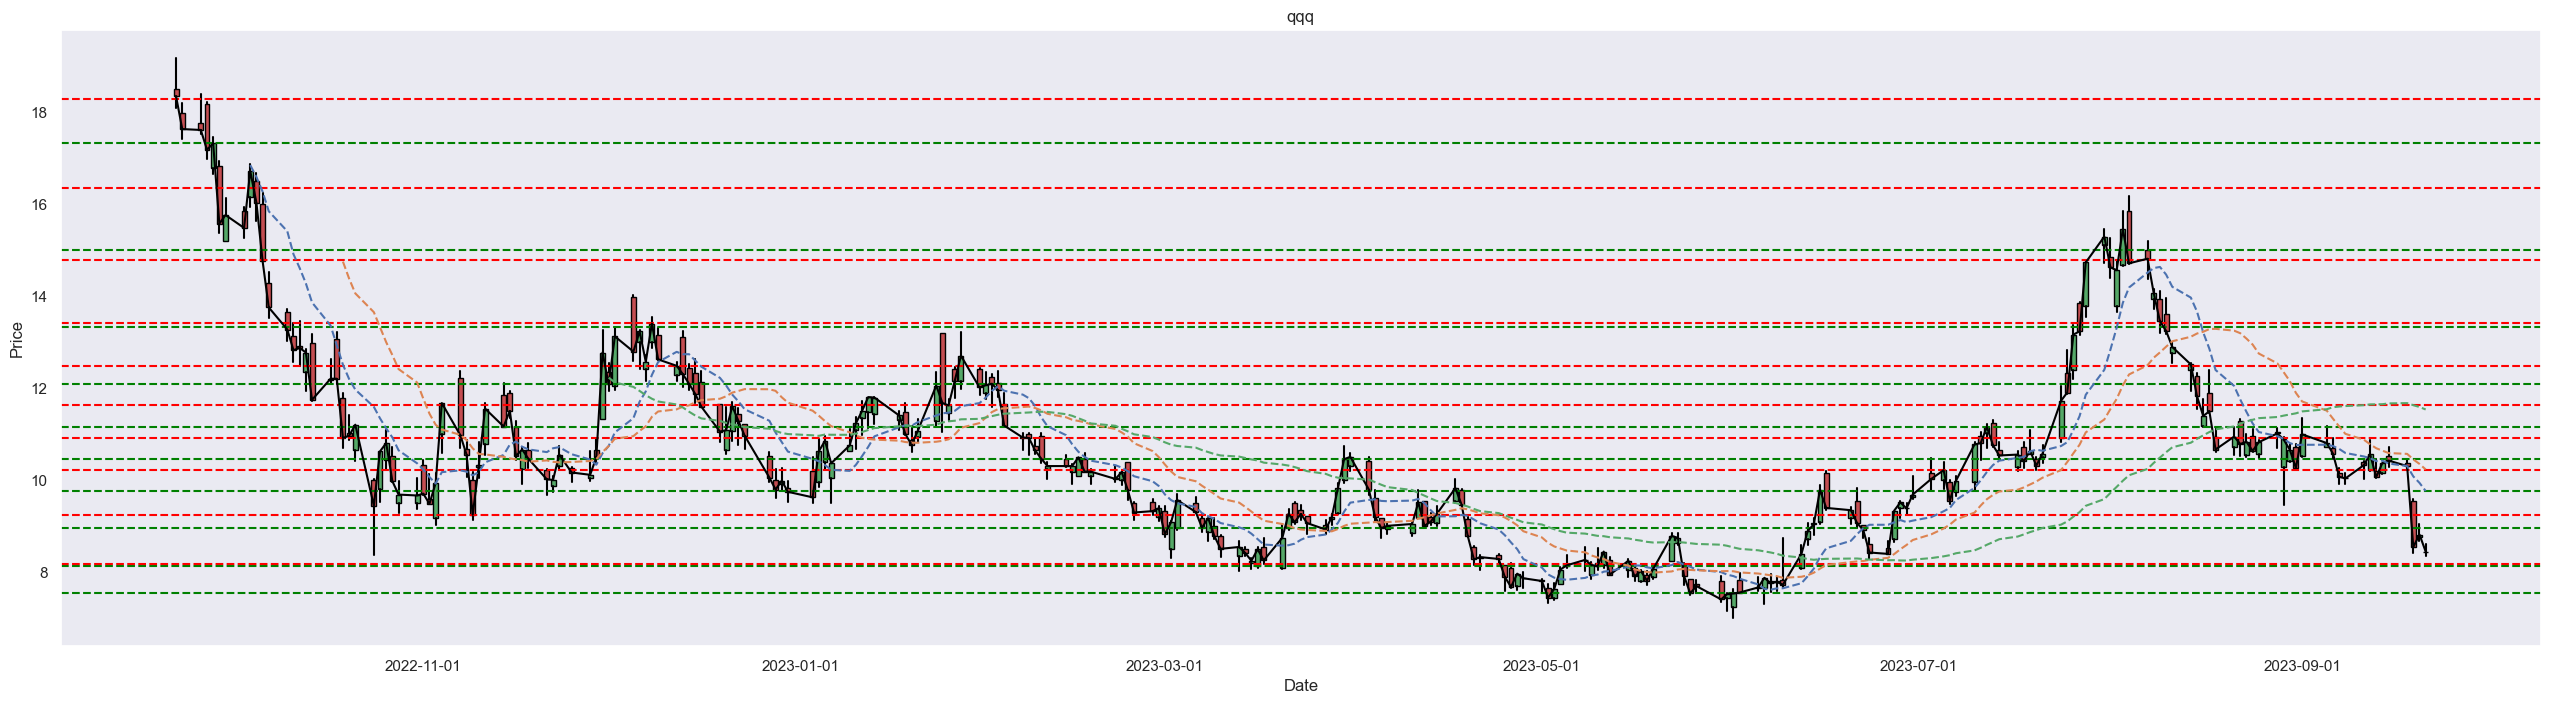

In [121]:
test_option_trading('nio')

NVDA 

9/22

* previous stock price closing 410 ~ up 431.6, down 416.5, 381,7

* Break / reflect at support / resistance: reflect support 416.5

* ITM option traded price: call (415, expire 9/29), 11.33

* Option profitability EOD: 10.23, highest 11.9

backtest: support break by $4. need a short red/green line to confirm reflect

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 410.2 ~ up 431.5 , down 381.7
[[127.54023246]
 [160.58219612]
 [201.39529419]
 [229.06750107]
 [269.46072872]
 [300.87857056]
 [381.70499929]
 [416.52333069]
 [446.12103166]
 [471.97363559]]
[[131.69394724]
 [164.79431846]
 [208.16666412]
 [237.14285787]
 [277.10390044]
 [309.8457162 ]
 [397.4375    ]
 [431.51258112]
 [462.07333035]
 [488.34333038]]


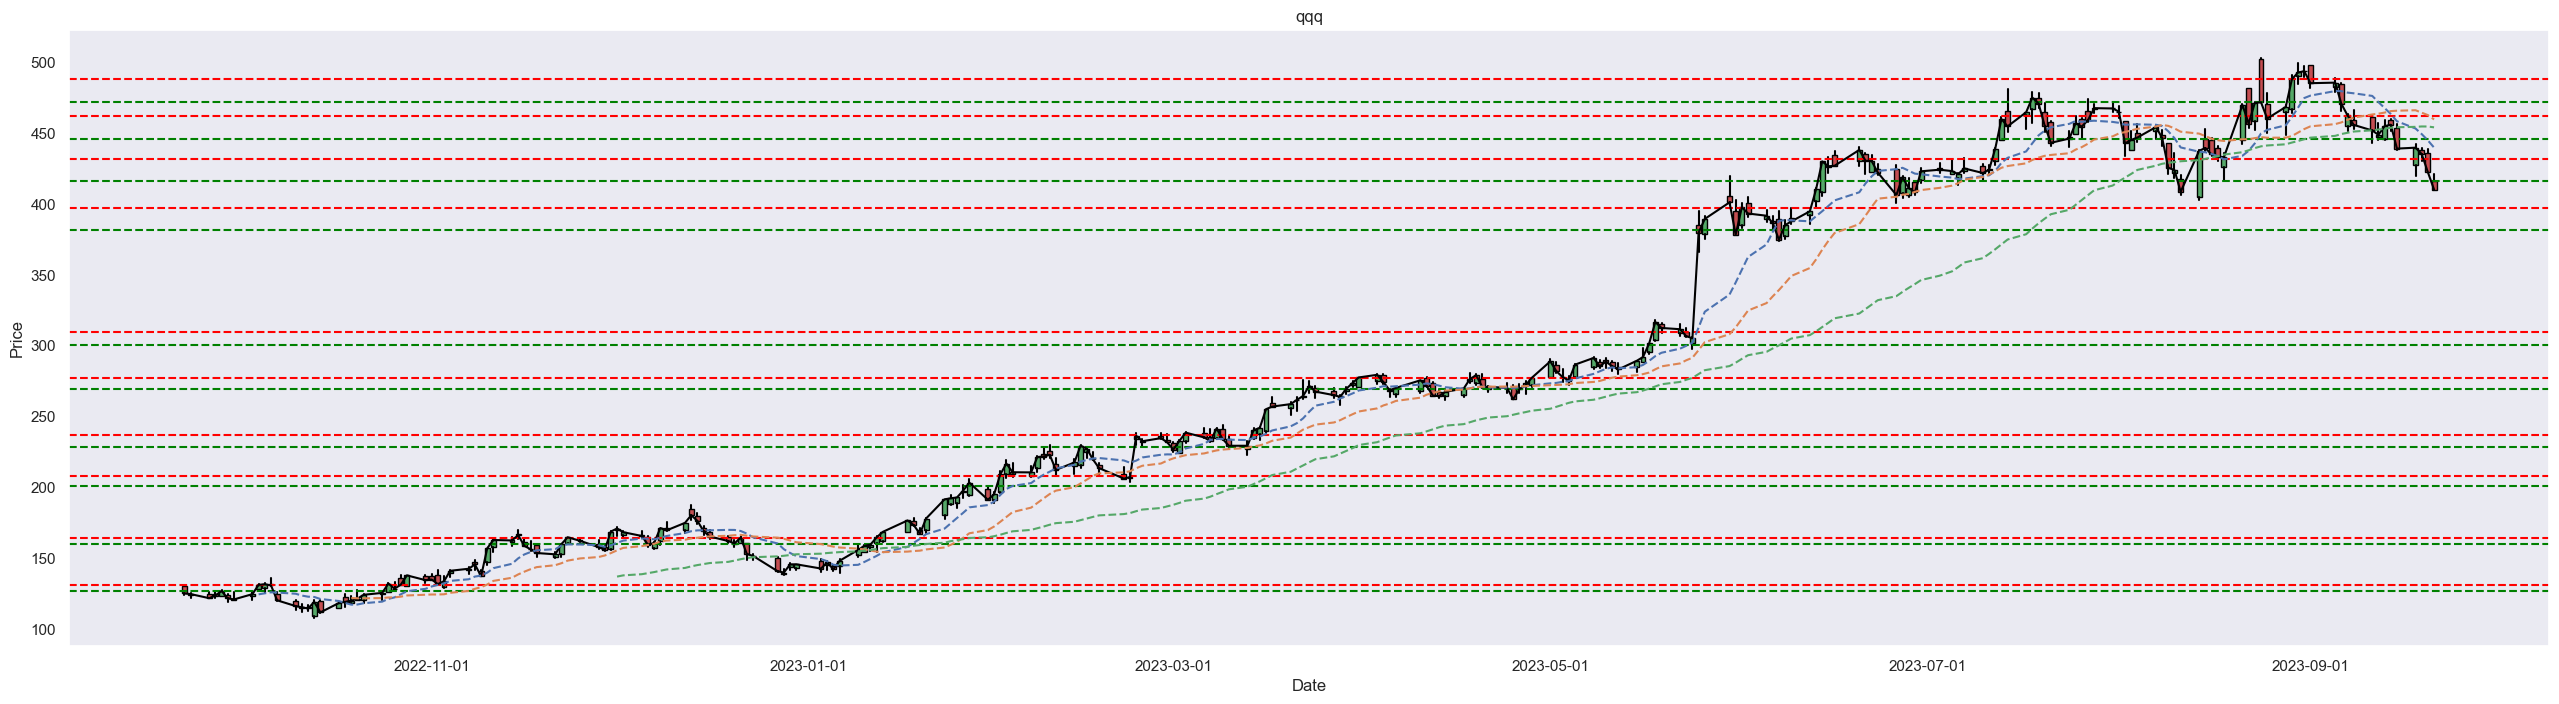

In [122]:
test_option_trading('nvda')

ATT

9/20

* Reflect at resistance 15.69

* ITM option traded price: put (16, expire 9/22), 0.34

* Option profitability EOD: 0.47
    
9/22

* previous stock price closing 15.3 ~ up 16, down 15.2

* Break / reflect at support / resistance: break support 15.2

* ITM option traded price: put (15.5, expire 9/29), 0.4

* Option profitability EOD: 0.42

backtest: long red line confirm break of support

[*********************100%***********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
previous stock price closing 15.3 ~ up 16.0 , down 15.3
[[14.03166668]
 [14.57884612]
 [15.26185191]
 [15.84233335]
 [16.82285731]
 [17.52999995]
 [18.2072725 ]
 [18.75322588]
 [19.0994118 ]
 [19.72526309]]
[[14.23000002]
 [14.75086959]
 [15.28388892]
 [15.95318183]
 [17.02000005]
 [17.75909094]
 [18.54874988]
 [19.19458338]
 [19.71320007]
 [20.52749991]]


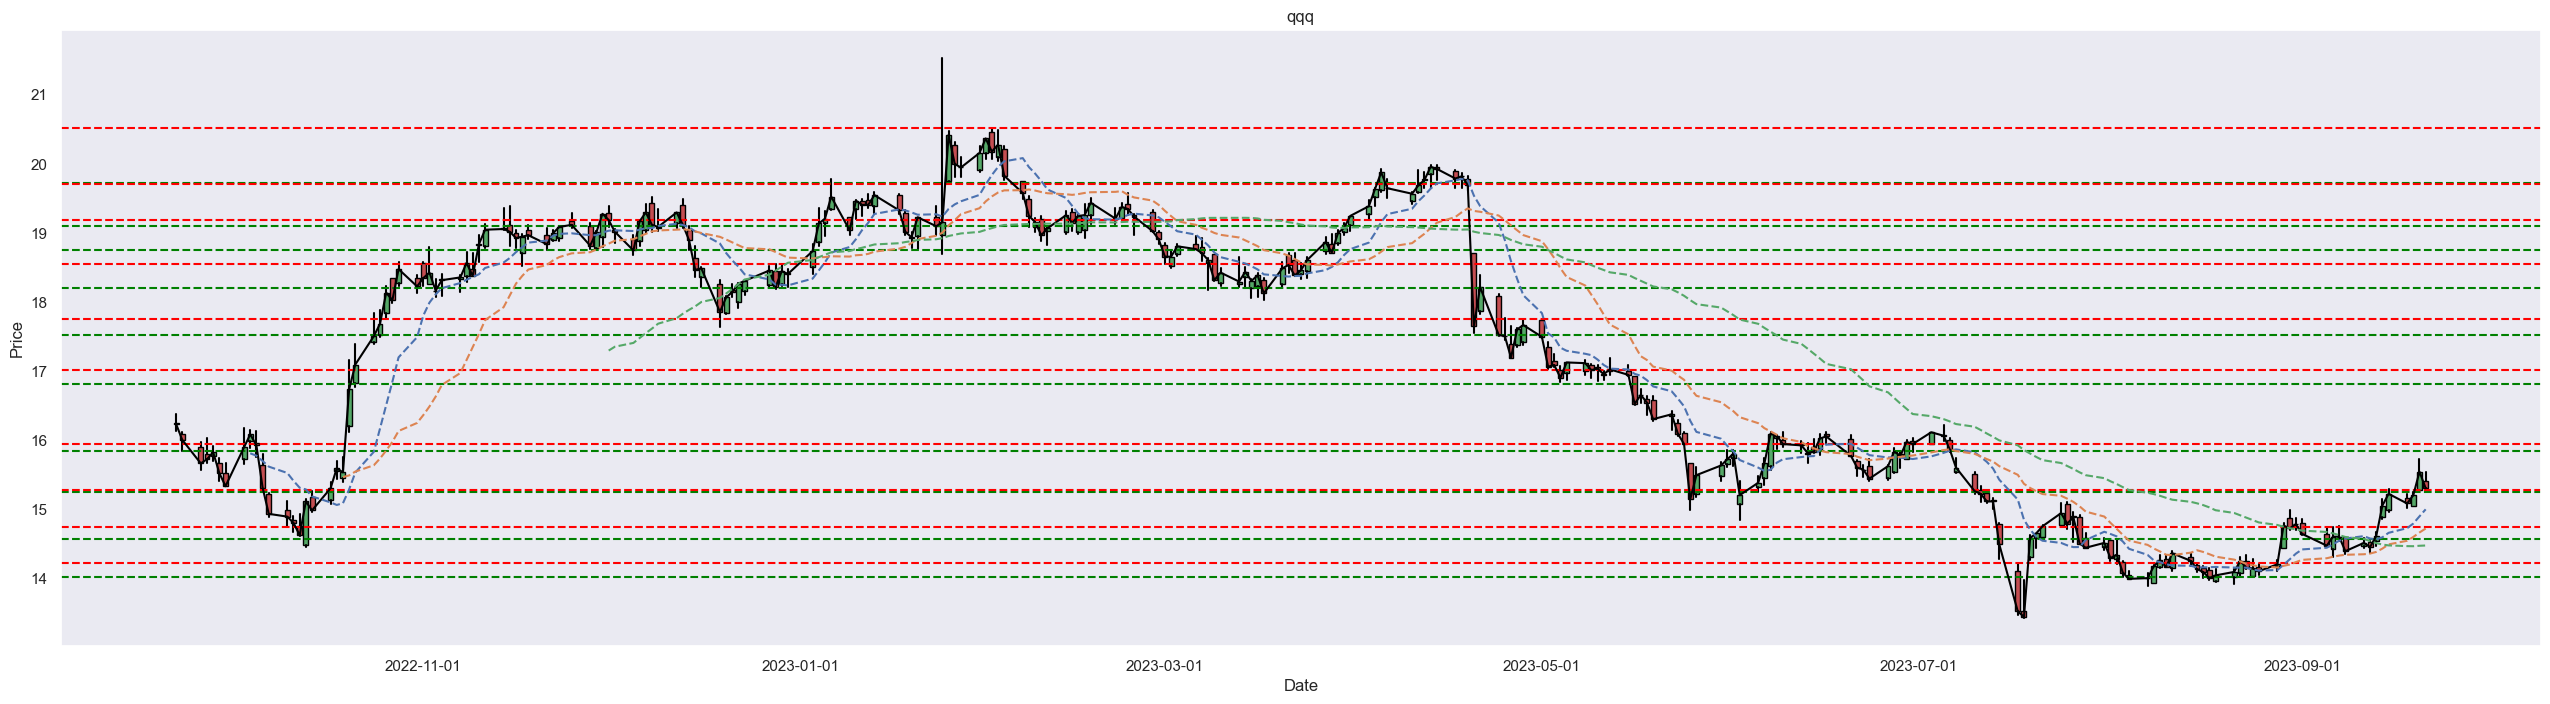

In [123]:
test_option_trading('t')